<h1 style="font-size:30px;text-align: center;">- Affective computing  - Final Project -</h1>
<h1 style="font-size:25px;text-align: center;">- Tweets in Croatian - Sentiment Analysis -</h1>

<span style="display:block;text-align:center">![Algebra](https://repozitorij.algebra.hr/sites/repozitorij.algebra.hr/files/algebra_subbrand_vu_color-black_h_1.png)</span>

<span style="display:block;text-align:center">=============================================================================================================</span>

<span style="display:block;text-align:center"><b>*Made: February 2022.* </b></span>

<span style="display:block;text-align:center"><b>*Authors: Mislav Spajić, univ. bacc. ing. agr. & Hrvoje Kopić, univ. bacc. ing. cheming.*</b></span>

<span style="display:block;text-align:center"><b>*Menthor: Igor Mijić , mag. ing. el. techn. inf.*</b></span>

In [1]:
# Prerequisites - packages that are not in installed in google colab
%%capture
!pip install classla
!pip install tweet-preprocessor
!pip install transformers
!pip install text-hr

In [3]:
# Importing all the needed packages
import numpy as np
import pandas as pd
import preprocessor as pre
import classla
import string
import regex as re
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt


from text_hr import get_all_std_words
from wordcloud import WordCloud, ImageColorGenerator
from transformers import RobertaModel
from torch.utils.data import Dataset, DataLoader
from statistics import mean
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import drive
from fastai.text import *
from fastai.metrics import *
from transformers import RobertaTokenizer
from transformers import RobertaModel

In [4]:
classla.download('hr')

2022-02-08 10:17:41 INFO: Downloading these customized packages for language: hr (Croatian)...
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |
| depparse  | standard |
| ner       | standard |
| pretrain  | standard |

2022-02-08 10:19:49 INFO: Finished downloading models and saved to /root/classla_resources.


In [5]:
# Some initial setup
pre.set_options(pre.OPT.SMILEY, pre.OPT.NUMBER) # https://github.com/s/preprocessor
regx = re.compile(r'[^\w\s]+')
seed = 42 # Setting seed for reproducibility
nlp = classla.Pipeline('hr', processors='tokenize,pos,lemma')

2022-02-08 10:19:49 INFO: Loading these models for language: hr (Croatian):
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |

2022-02-08 10:19:49 INFO: Use device: gpu
2022-02-08 10:19:49 INFO: Loading: tokenize
2022-02-08 10:19:49 INFO: Loading: pos
2022-02-08 10:20:57 INFO: Loading: lemma
2022-02-08 10:21:04 INFO: Done loading processors!


In [6]:
# Mounting drive to transfer input data to colab env
# Input data was created by running 'tweet_scraper.py' locally and then uploaded to Google Drive
drive.mount('/gdrive')

Mounted at /gdrive


In [7]:
%cd /gdrive/My Drive/

/gdrive/My Drive


In [8]:
%cp -av tweet_output.csv /content/tweet_output.csv

'tweet_output.csv' -> '/content/tweet_output.csv'


In [9]:
%cd /content

/content


In [10]:
%ls

sample_data/  tweet_output.csv


In [13]:
# Defining helper functions for cleaning of dataset and normalization of tweets
def norm_tweets(df):
    df['text'] = df.apply(lambda _: '', axis=1)
    # remove emoticons and numbers
    df.text = df.general_text.apply(lambda x: pre.clean(x))
    # convert to lower case
    df.text = df.text.str.lower()
    # remove links
    df.text = df.text.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
    df.text = df.text.apply(lambda x:
                        re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
    df.text = df.text.apply(lambda x: re.sub(r'{link}', '', x))
    df.text = df.text.apply(lambda x: re.sub(r"\[video\]", '', x))
    # substitute 'RT @' with '@'
    df.text = df.text.apply(lambda x: re.compile('rt @').sub('@', x).strip())
    # Remove usernames. The usernames are any word that starts with @.
    df.text = df.text.apply(lambda x: re.sub('\@[a-zA-Z0-9]*', '', x))
    # convert '#' to '' and '_' to ' ' and ':' to ''
    df.text = df.text.apply(lambda x:
                        x.replace("#", "").replace("_", " ").replace(":", ""))
    # remove rest of numbers
    df.text = df.text.apply(lambda x: re.sub(r'\d+', '', x))
    # remove punctuations - we will be treating a tweet like a single sentence
    # seems logical move to simplify things a bit
    df['text'] = [regx.sub('', x) for x in df['text'].tolist()]
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    df.text = df.text.apply(lambda x: re.sub('\s+', ' ', x))
    df.text = df.text.str.strip()
    df['text_lem'] = [lemmatizer(x) for x in df['text']]
    
    return df


def preprocess(df):
    n_rows = len(df)
    # if there are duplicate tweets with same label keep one
    df = df.drop_duplicates(subset=['id', 'sentiment'], keep='first')
    print(f'Dropped {n_rows - len(df)} duplicate rows with same Label')
    # now there are only duplicates with different label, so drop both
    n_rows = len(df)
    df = df.drop_duplicates(subset=['id'], keep=False)
    print(f'Dropped {n_rows - len(df)} duplicate rows with different Label')
    
    return df


def preprocess2(df):
    print('\n')
    n_rows = len(df)
    df = norm_tweets(df)
    # if there are duplicate tweets with same text and sentiment label keep one
    df = df.drop_duplicates(subset=['text_lem' , 'sentiment'], keep='first')
    print(f'Dropped {n_rows - len(df)} duplicate rows with same text and label')
    # now there are only duplicates with different label, so drop both
    n_rows = len(df)
    df = df.drop_duplicates(subset=['text_lem'], keep=False)
    print(f'Dropped {n_rows - len(df)} duplicate rows with different Label')
    print(f'Final number of rows: {len(df)}')

    return df

def lemmatizer(x):
    doc = nlp(x)
    word_tokens = [word.lemma for sent in doc.sentences for word in sent.words]
    
    return ' '.join(word_tokens)
    # rejoining since we will use pretrained tokenizer (Hugging face - RoBERTa)

In [14]:
tweets_df = pd.read_csv("tweet_output.csv")
# Preprocessing
df = preprocess(tweets_df)
df = preprocess2(df)

Dropped 8172 duplicate rows with same Label
Dropped 4602 duplicate rows with different Label


Dropped 8139 duplicate rows with same text and label
Dropped 1852 duplicate rows with different Label
Final number of rows: 53527


In [15]:
df["anotator"].value_counts()  # All same anotator - no need to stratify by an.

33    53527
Name: anotator, dtype: int64

In [16]:
df["sentiment"].value_counts() # Not ideal, but not bad distribution of response var. 

Positive    27790
Neutral     12888
Negative    12849
Name: sentiment, dtype: int64

In [17]:
# Stop words list, won't be used for modelling, just for wordcloud plot
stop=[]
for word_base, l_key, cnt, _suff_id, wform_key, wform in get_all_std_words():
    stop.append(word_base)

In [18]:
# helper functions for wordcloud plots
def isNaN(num):
    return num != num

def word_cloud(wd_list):
    all_words = ' '.join([text for text in wd_list if isNaN(text) != True])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

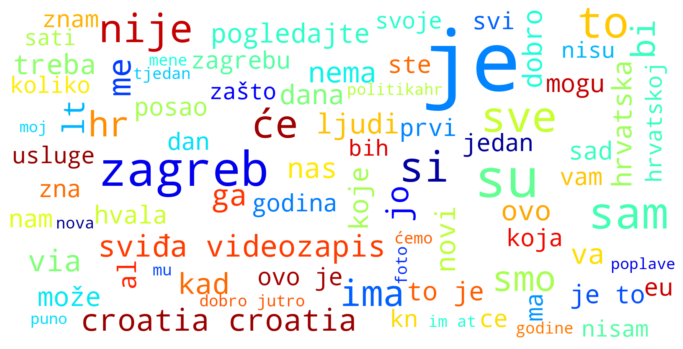

In [19]:
# cleaned text wordcloud   
word_cloud(df['text'])

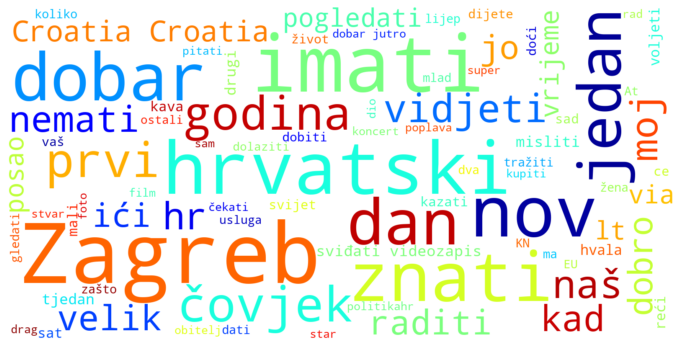

In [20]:
# preprocessed (lemmatized) text wordcloud
word_cloud(df['text_lem'])

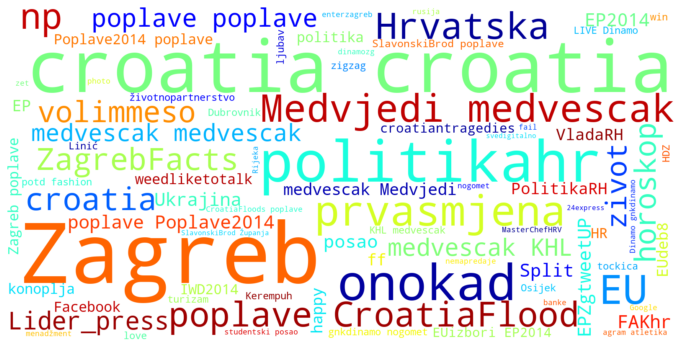

In [21]:
# hashtags Wordcloud
word_cloud(df['general_hashtags'])

In [22]:
# Encoding labels to integers
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

In [23]:
# Pretrained roBERTa ( BERT based model from facebook) tokenizer
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [48]:
# We will be using FastAI API so we need to define some classes and objects to wrap things up 
class FastAiRobertaTokenizer(BaseTokenizer):
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        return ["<s>"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["</s>"]

In [49]:
fastai_tokenizer = Tokenizer(tok_func = FastAiRobertaTokenizer(roberta_tok, max_seq_len=256), pre_rules=[], post_rules=[])

In [50]:
path = Path()
roberta_tok.save_vocabulary(path) 
with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

In [51]:
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)
         
class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)
        
def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

In [52]:
class RobertaDataBunch(TextDataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)


In [53]:
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

In [54]:
feat_cols = "text_lem"
label_cols = "sentiment"

In [55]:
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)
data = RobertaTextList.from_df(df, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(valid_pct=0.2, seed=seed) \
    .label_from_df(cols=label_cols,label_cls=CategoryList) \
    .databunch(bs=4, pad_first=False, pad_idx=0)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [56]:
class CustomRobertatModel(nn.Module):
    def __init__(self,num_labels=3):
        super(CustomRobertatModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained("roberta-base", return_dict=False)
        self.dropout = nn.Dropout(.15)
        self.classifier = nn.Linear(768, num_labels)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask)
        logits = self.classifier(pooled_output)        
        return logits

In [57]:
roberta_model = CustomRobertatModel()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
learn = Learner(data, roberta_model, metrics=[accuracy])

In [59]:
learn.lr_find()


epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


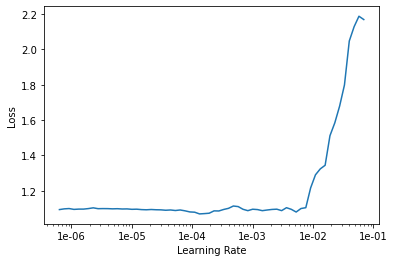

In [60]:
learn.recorder.plot()

In [61]:
# https://fastai1.fast.ai/callbacks.one_cycle.html

In [62]:
learn.model.roberta.train() # set roberta into train mode
learn.fit_one_cycle(3, max_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.919718,0.877893,0.598786,31:28
1,0.709216,0.878776,0.632882,32:36
2,0.734872,0.806450,0.649510,31:34


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


According to ( https://www.bib.irb.hr/1155535 ) this seems like a pretty good result.

# Conclusion:

It was a very fun and interesting project to do. We' ve learned the ins and outs of scraping and cleaning tweets and nuances of Croatian language in NLP. We have experimented with various new Python packages and tried transfer learning in NLP domain. BERT based models which are language and task universal, like roBERTa we have used here, seem so powerful and even unreal, state of this domain is really on a good track.

# Possible improvements in project:

Dealing with data leakage issues by constructing a pipeline for model training and then testing on holdout set.

Hyperparameter optimization. 

Ensemble of multiple models.

Not cleaning emoticons and using them in analysis.

Using POS and NRE features that can be generated by classla pipeline implemented in this notebook, they are not used at the moment.

Using some more preprocessing techniques like i.e. diacritic restoration tools. (https://github.com/clarinsi/redi)

